In [19]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

In [35]:
class ConHelper:

    def __init__(self,
              Rc= 1000,
              Fmax=6 * 1e8,
              Cmax=5*1e-3):
        """
        Intial Method for Continous Helper
        param Rc: Integer
        param Fmax: Float
        param Cmax: Float
        return: None  
        """
        if Rc < 0 or Fmax < 0 or Cmax < 0:
            raise Exception("Initial Values for Helper must be positive")

        self.Rc = Rc
        self.Fmax = Fmax
        self.Cmax = Cmax

        self.d = None
        self.f = None
        self.c = None

    def reset(self):
        self.d = np.random.uniform(low=1e-2, high=self.Rc)
        # Create F Max
        self.f = np.random.normal(loc=self.Fmax/2.0, scale=self.Fmax/2.0)
        self.f = max(self.Fmax / 1000.0, min(self.f, self.Fmax))
        # Create C Max
        self.c = np.random.normal(loc=self.Cmax/2.0, scale=self.Cmax/2.0)
        self.c = max(1e-8, min(self.c, self.Cmax))

    def transit(self):
        """
        perform transiting to new state
        """
        # Create d
        self.d = np.random.normal(loc=self.d, scale=self.Rc/2.0)
        self.d = max(1e-2, min(self.d, self.Rc))
        # Create f
        self.f = np.random.normal(loc=self.f, scale=self.Fmax/2.0)
        self.f = max(self.Fmax / 1000.0, min(self.f, self.Fmax))
        # Create c
        self.c = np.random.normal(loc=self.c, scale=self.Cmax/2.0)
        self.c = max(1e-8, min(self.c, self.Cmax))

    def cal_computation_fee(self, k, L):
        """
        Calculate the Computation fee of L/k bits
        param k: Integer - Number of sub-packages
        param L: Integer - Total Bits needed to compute
        """
        k = float(k)
        L = float(L)
        d_com = (1.0 / self.f) * (L / k)
        return d_com

    def cal_offload_fee(self, k, L):
        """
        Calculate OffLoad Fee
        param k: Integer - Number of sub-packages
        param L: Integer - Total Bits needed to upload
        param B: Float Bandwidth
        param PT: Float the power of transmitted signal
        param c0: The speed of light
        param FB: The frequency of the radio wave
        """
        k, L = float(k), float(L)
        CO = 3*1e8
        FB = 1e8
        B = 40.0*1e12
        PT = 0.25
        sigma = 0.5 # Without Noise

        pr = PT * (CO** 2) / (((np.pi ** 2) * FB * self.d) ** 2)
        rn = B * np.log(1.0 + pr / (1.0-sigma)) 

        return L / (k * rn)

    def cal_cost_fee(self, k, L):
        return self.c * self.cal_computation_fee(k, L) + 1e-4

    def show_cur_state(self):
        print("d: {:.3f}, f: {:.3f}, c: {:.10f}".format(self.d, self.f, self.c)) 


class ConTaskOffloadEnv(gym.Env):

    def __init__(self,
                n_helpers=5,
                Rc= 1000.0,
                Fmax=6*1e8,
                Cmax=5*1e-3,
                Lmax=300*1e4,
                alpha1=2.0,
                alpha2=1e3,
                seed=1):
        """
        Initial Method
        param n_helpers: Integer - The number of helper in the system
        param Rc: Float - Radius
        param Fmax: Float - Maximum Computing Capability
        param Cmax: Float
        param Lmax: Integer - Maximum Package Size
        param alpha1: Float - Weight for Computing Time
        param alpha2: Float - Weight for Computing Cost 
        return None
        """
    
        self.helpers = {}
        self.n_helpers = n_helpers
        self.Rc = Rc
        self.Fmax = Fmax
        self.Cmax = Cmax
        self.Lmax = Lmax
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        self.obser_dims = n_helpers * 3 + 1
        self.act_dims = n_helpers + 1
        self.step_counter = 0 

    def reset(self):
        self.L = int(np.random.uniform(low=self.Lmax/10.0, high=self.Lmax))
        self.step_counter = 0

        for idx in range(self.n_helpers):
            self.helpers[idx] = ConHelper(self.Rc, self.Fmax, self.Cmax)
            self.helpers[idx].reset()

        self.client_f = np.random.normal(loc=6*1e5, scale=1e2)

        # self.TL = self.L / self.client_f
        self.state = self.get_state()

        return self.state

  
    def get_state(self):
        state = [self.L / self.Lmax]
        for key in sorted(list(self.helpers.keys())):
            helper = self.helpers[key]
            state.append(helper.d/ helper.Rc)
            state.append(helper.f / helper.Fmax)
            state.append(helper.c / helper.Cmax)
        state = np.array(state)

        return state

    def step(self, action):
        # Perform Actions
        # Actions' format [k, a1, a2, a3, ..., an]
        k = int(action[0])
        n_sel_helpers = int(np.sum(action[1:]))
        accepted = (k == n_sel_helpers)
        assert accepted, "action is not satify the condition!"

        self.step_counter += 1
    
        com_cost, consum_time = 0, []
        for idx in sorted(list(self.helpers.keys())):
            if action[idx+1] == 0:
                consum_time.append(-np.Inf)
                continue

            com_time = self.helpers[idx].cal_computation_fee(k, self.L)
            off_time = self.helpers[idx].cal_offload_fee(k, self.L)
            consum_time.append(com_time + off_time)
            com_cost += self.helpers[idx].cal_cost_fee(k, self.L)

        # Get k-th minimum
        consum_time = sorted(consum_time)
        consum_time = max(consum_time[-k:])

        # Calculate The Reward for This Action
        stand_time = self.L / self.client_f
    
        if consum_time > stand_time:
            time_reward = -stand_time
        else:
            time_reward = stand_time - consum_time

        time_reward = time_reward * self.alpha1
        cost_reward = com_cost * self.alpha2
        total_reward = time_reward - cost_reward

        reward = [total_reward, time_reward, cost_reward]

        # Go To The Next Stage
        self.L = int(np.random.uniform(low=self.Lmax/10.0, high=self.Lmax))
    
        for key in self.helpers.keys():
            self.helpers[key].transit()

        next_state = self.get_state()

        if self.step_counter == 50:
            done = True
        else:
            done = False

        return next_state, reward, done

    def sam_action(self):
        """
        Random Sample Action for Uniform Distribution
        Action' s format - [k, a1, a2, a3, .., an] 
        """
        action = [0 for _ in range(self.n_helpers)]
        k = random.randint(1, self.n_helpers)

        sel_idxs =np.random.permutation(self.n_helpers)[0:k]

        for idx in list(sel_idxs):
            action[idx] = 1
    
        action = [k] + action
        return action

In [36]:
import tensorflow as tf

In [37]:
# Define Backbone Architecture
class Backbone:
    
    def __init__(self, out_dims):
        
        self.layers = [
            tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=out_dims)
        ]
    
    def __call__(self, inputs):
        # Call Function
        x = inputs
        outputs = self.call(inputs)
        return outputs
    
    def call(self, inputs):
        # Perform
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x


In [38]:
class DeepQLearning:
    
    """ Deep Q-Learning Implementation """
    
    def __init__(self,
                 n_state_dims,
                 n_action_dims,
                 backbone):
        """
        Initial Method
        param: n_action_dims - Integer [a1, a2, ..., an]
        param: n_state_dims - Integer
        param: backbone - Function
        return None
        """
        self.n_state_dims = n_state_dims
        self.n_action_dims = n_action_dims
        self.backbone = backbone
        
        self.states = tf.compat.v1.placeholder(dtype=tf.float32,
                                    shape=(None, self.n_state_dims))
        self.next_states = tf.compat.v1.placeholder(dtype=tf.float32,
                                    shape=(None, self.n_state_dims))
        self.actions = tf.compat.v1.placeholder(dtype=tf.float32,
                                    shape=(None, self.n_action_dims))
        self.rewards = tf.compat.v1.placeholder(dtype=tf.float32,
                                    shape=(None, ))
        self.dones = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None,))
        
        self.gamma = tf.compat.v1.placeholder(dtype=tf.float32, shape=None)
        self.lr = tf.compat.v1.placeholder(dtype=tf.float32, shape=None)
        
        self._define_model()
        
    def _define_model(self):
        # Model Definition
        n_helpers = self.n_action_dims
        
        self.agent = self.backbone(n_helpers * 2)
        
        state_outputs = self.agent(self.states)
        next_state_outputs = self.agent(self.next_states)
        # Calculate state rewards and k probability
        state_ks = state_outputs[:, 0:n_helpers]
        state_rewards = state_outputs[:, -n_helpers:]
        
        state_rewards = state_rewards * self.actions[:, -n_helpers:]
        state_rewards = tf.reduce_mean(state_rewards, axis=-1)
        
        # Calculate next state rewards and next k probability
        next_state_ks = next_state_outputs[:, 0:n_helpers]
        next_state_ks = tf.nn.softmax(next_state_ks, axis=-1)
        next_state_ks = tf.math.argmax(next_state_ks, axis=-1)
        next_state_ks = next_state_ks + 1
        
        next_state_rewards = next_state_outputs[:, -n_helpers:]
        next_state_rewards = tf.sort(next_state_rewards,
                                     direction="DESCENDING",
                                     axis=-1)
        mask = tf.sequence_mask(next_state_ks,
                                maxlen=n_helpers,
                                dtype=tf.float32)
        
        next_state_rewards = next_state_rewards * mask
        next_state_rewards = tf.reduce_mean(next_state_rewards, axis=-1)
        
        labels = next_state_rewards * (1.0 - self.dones) * self.gamma + self.rewards 
        
        self.loss = tf.losses.mean_squared_error(labels, state_rewards)
        optimizer = tf.compat.v1.train.AdamOptimizer(self.lr)
        self.opt = optimizer.minimize(loss=self.loss)
        
        # Get K and Rewards for Predicting Phase
        self.pred_ks = tf.math.argmax(
                            tf.nn.softmax(
                                state_outputs[:, 0:n_helpers],
                                axis=-1),
                            axis=-1)
        self.pred_ks = self.pred_ks + 1
        self.pred_rewards = state_outputs[:, -n_helpers:]
        
        self.outputs = [self.pred_ks, self.pred_rewards]

In [39]:
import random

class MemoryBase(object):
    # Define Abstract Class for MemmoryBase
    def __init__(self, capability=100000):
        """
        Initialize method for creating a new instance of memory based
        + Params: capability: Integer
        """
        self.capability = capability
        self.queue = {
                        "s":[],
                        "a":[],
                        "ns":[],
                        "r":[],
                        "d":[]
                    }
        self.cur_size = 0
        self.pris = None

    def insert_samples(self, samples):
        """
        Perform Inserting New Observations into Memory
        + Params: samples
        """
        pass

    def sel_samples(self, batch_size):
        """
        Perform Selecting Observations from Previous
        """
        pass

    def clrqueue(self):
        """
        Perform Clearing Observations in this Queue
        """
        pass

class Memory(MemoryBase):
    """
    Declare Memory for Training Deep Reinforcement Learning
    """
    def __init__(self, capability):
        super(Memory, self).__init__(capability)

    
    def insert_samples(self, samples):
        """
        Insert Samples to Queue
        + Params: samples: Dictionary
        + Returns: None 
        """
        if self.queue.keys() != samples.keys():
            raise Exception("Inserted Samples are't the same format")

        num_sams = len(samples["s"])

        for key in self.queue.keys():
            self.queue[key] = samples[key] + self.queue[key]
        
        if self.cur_size + num_sams <= self.capability:
            self.cur_size += num_sams
            return 

        # Remove Over Samples in a Queue
        for key in self.queue.keys():
            self.queue[key] = self.queue[key][0:self.capability]
        
        self.cur_size = self.capability
        return

    def sel_samples(self, batch_size):
        """
        Select n samples from queue
        + Params: batch_size: Integer
        """
        batch = {"s":[], "a":[], "ns":[], "r":[], "d":[]}
        
        if batch.keys() != self.queue.keys():
            raise Exception("Format of Batch and Queue must be same")

        if self.cur_size <= batch_size:
            return self.queue 

        idxs = random.sample(list(range(self.cur_size)), batch_size)

        for idx in idxs:
            for key in self.queue.keys():
                batch[key].append(self.queue[key][idx])
        
        return batch

    def clrqueue(self):
        """
        Perform Clearing Observations
        """
        self.cur_size = 0
        for key in self.queue.keys():
            self.queue[key] = []


In [71]:
import os

def sel_dql_action(env,
                   model=None,
                   obs=None,
                   sess=None,
                   epsilon=None):
    
    """Select Deep Q Learning Method"""
    if np.random.random() < epsilon:
        action = env.sam_action()  
        return action
    else:
        if len(obs.shape) == 1:
            obs = np.expand_dims(obs, axis=0)
        if len(obs.shape) != 2:
            raise Exception("Observation Dimension must be 2 but {}".\
                format(len(obs.shape)))    
        # Run Inference
        [k, values] = sess.run([model.pred_ks, model.pred_rewards], 
                            feed_dict={
                                model.states: obs
                            })
        k = k[0]
        values = values[0]
        sorted_idxs = list(np.argsort(values, axis=-1))
        sorted_idxs.reverse()
        
        action = [0 for _ in range(env.n_helpers)]
        
        for idx in sorted_idxs[:k]:
            action[idx] = 1.0
        action = [k] + action
        return action
        
tf.reset_default_graph()

env = ConTaskOffloadEnv(n_helpers=5,
                        Rc= 1000.0,
                        Fmax=6*1e8,
                        Cmax=5*1e-3,
                        Lmax=300*1e4,
                        alpha1=1.0,
                        alpha2=1e3,
                        seed=1)

action_dims = env.n_helpers
state_dims = env.obser_dims

print("The Number Dimensions of Actions: {}\nThe Number Dimensions of Spaces {}"\
      .format(action_dims, state_dims))

config = {
    "buffer_size": 10000,
    "lr": 0.001,
    "gamma": 0.1,
    "num_episodes": 3000,
    "batch_size": 512,
    "max_eps": 1.0,
    "min_eps": 0.1,
    "gpu_idx": "1"
}

container = Memory(config["buffer_size"])
model = DeepQLearning(n_state_dims=state_dims,
                     n_action_dims=action_dims,
                     backbone=Backbone)

print("Build Agent Successfully!")

os.environ["CUDA_VISIBLE_DEVICES"] = config["gpu_idx"]
gpu_option = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_option))
sess.run(tf.global_variables_initializer())

log_total_reward, log_comp_reward, log_cost_reward, best_reward, log_loss = [], [], [], -np.Inf, {}

# Perform Training Phase
epsilon = config["max_eps"]
dis_lr = 1.0

for episode in range(config["num_episodes"]):
    state = env.reset()
    done = False
    if (episode + 1) % 50 == 0:
        epsilon *= 0.99
    epsilon = max(epsilon, config["min_eps"])
    
    while not done:
        action = sel_dql_action(env, model, state, sess, epsilon)
        
        next_state, reward, done = env.step(action)
        
        container.insert_samples({'s': [state],
                                'a':[action],
                                'ns':[next_state],
                                'r':[float(reward[0])],
                                'd':[float(0.0)]})
        state = next_state
    
    batch_data = container.sel_samples(config["batch_size"])
    states = np.array(batch_data["s"])
    actions = np.array(batch_data["a"])
    next_states = np.array(batch_data["ns"])
    rewards = np.array(batch_data["r"])
    dones = np.array(batch_data["d"])
    
    [_, loss] = sess.run([model.opt, model.loss],
                        feed_dict={
                            model.states: states,
                            model.next_states:next_states,
                            model.actions: actions[:, 1:],
                            model.rewards: rewards,
                            model.dones: dones,
                            model.gamma: config["gamma"],
                            model.lr: config["lr"]/dis_lr})
    
    
    # print("Iteration {}: - Loss {}".format(episode, loss))
    
    # Perfome Evaluation
    if (episode) % 5 == 0:
        
        avg_total, avg_comp, avg_cost = [], [], []
        
        for game in range(5):
            state = env.reset()
            done = False
            total_reward, comp_reward, cost_reward = 0, 0, 0
            
            while not done:
                action = sel_dql_action(env, model, state, sess, -np.Inf)
                next_state, reward, done = env.step(action)
                state = next_state
                
                total_reward += reward[0]
                comp_reward += reward[1]
                cost_reward += reward[2]
            
            avg_total.append(total_reward)
            avg_comp.append(comp_reward)
            avg_cost.append(cost_reward)
            
        avg_total = np.mean(avg_total)
        avg_comp = np.mean(avg_comp)
        avg_cost = np.mean(avg_cost)
        
        log_total_reward.append(avg_total)
        log_comp_reward.append(avg_comp)
        log_cost_reward.append(avg_cost)
        log_loss[episode] = loss
        
        print("Episode {} - Total Reward {:.5f} - Computation Reward {:.5f} Cost Reward {}".\
              format(episode, avg_total, avg_comp, avg_cost))
        

The Number Dimensions of Actions: 5
The Number Dimensions of Spaces 16
Build Agent Successfully!
Episode 0 - Total Reward 30.69913 - Computation Reward 109.23063 Cost Reward 78.53149913931512
Episode 5 - Total Reward 43.07032 - Computation Reward 121.87825 Cost Reward 78.80793016149087
Episode 10 - Total Reward 53.83841 - Computation Reward 112.96852 Cost Reward 59.13010927653405
Episode 15 - Total Reward 27.20133 - Computation Reward 104.74820 Cost Reward 77.54687682852777
Episode 20 - Total Reward 26.58137 - Computation Reward 109.44529 Cost Reward 82.86391468016815
Episode 25 - Total Reward 25.58217 - Computation Reward 110.35962 Cost Reward 84.77745555695407
Episode 30 - Total Reward 24.24169 - Computation Reward 105.63405 Cost Reward 81.39235370697129
Episode 35 - Total Reward 7.20986 - Computation Reward 99.70436 Cost Reward 92.49450440882808
Episode 40 - Total Reward 34.10404 - Computation Reward 109.98763 Cost Reward 75.88359000688337
Episode 45 - Total Reward 35.95073 - Comput

Episode 420 - Total Reward 99.36587 - Computation Reward 119.65866 Cost Reward 20.292780691986952
Episode 425 - Total Reward 86.74665 - Computation Reward 117.10976 Cost Reward 30.363115553646868
Episode 430 - Total Reward 87.94794 - Computation Reward 115.47515 Cost Reward 27.527209097303103
Episode 435 - Total Reward 89.49945 - Computation Reward 119.85934 Cost Reward 30.3598966847622
Episode 440 - Total Reward 95.35550 - Computation Reward 122.07930 Cost Reward 26.72380612704182
Episode 445 - Total Reward 90.82117 - Computation Reward 112.22243 Cost Reward 21.401262661825847
Episode 450 - Total Reward 101.08684 - Computation Reward 119.36233 Cost Reward 18.275491739380048
Episode 455 - Total Reward 84.14367 - Computation Reward 119.14972 Cost Reward 35.006043268226385
Episode 460 - Total Reward 81.56691 - Computation Reward 108.81798 Cost Reward 27.251071654575263
Episode 465 - Total Reward 99.89015 - Computation Reward 124.26604 Cost Reward 24.375887377574323
Episode 470 - Total Re

Episode 840 - Total Reward 94.49011 - Computation Reward 117.04830 Cost Reward 22.558189206342995
Episode 845 - Total Reward 88.87891 - Computation Reward 114.53195 Cost Reward 25.653040997529864
Episode 850 - Total Reward 88.46662 - Computation Reward 120.48568 Cost Reward 32.019063009046
Episode 855 - Total Reward 86.46709 - Computation Reward 121.43902 Cost Reward 34.97193203671965
Episode 860 - Total Reward 76.43333 - Computation Reward 108.48635 Cost Reward 32.05301446227934
Episode 865 - Total Reward 96.83735 - Computation Reward 120.48475 Cost Reward 23.64740148898142
Episode 870 - Total Reward 92.10209 - Computation Reward 119.06544 Cost Reward 26.963341243766433
Episode 875 - Total Reward 88.67496 - Computation Reward 112.08069 Cost Reward 23.4057253588501
Episode 880 - Total Reward 83.39592 - Computation Reward 120.83427 Cost Reward 37.43835434874918
Episode 885 - Total Reward 84.57355 - Computation Reward 111.48227 Cost Reward 26.908713135427554
Episode 890 - Total Reward 91

Episode 1260 - Total Reward 90.36294 - Computation Reward 124.05589 Cost Reward 33.69294931303798
Episode 1265 - Total Reward 81.85690 - Computation Reward 117.41663 Cost Reward 35.55972928730641
Episode 1270 - Total Reward 92.46985 - Computation Reward 120.56701 Cost Reward 28.09716165277905
Episode 1275 - Total Reward 78.43713 - Computation Reward 116.09277 Cost Reward 37.65563508845367
Episode 1280 - Total Reward 87.05321 - Computation Reward 119.08930 Cost Reward 32.03609346976602
Episode 1285 - Total Reward 74.81352 - Computation Reward 118.38869 Cost Reward 43.57517049623675
Episode 1290 - Total Reward 62.62444 - Computation Reward 113.72976 Cost Reward 51.105319110323045
Episode 1295 - Total Reward 76.17580 - Computation Reward 117.93931 Cost Reward 41.76351286262066
Episode 1300 - Total Reward 71.87656 - Computation Reward 116.04661 Cost Reward 44.170042991063866
Episode 1305 - Total Reward 78.28519 - Computation Reward 120.87945 Cost Reward 42.59426649172521
Episode 1310 - Tot

Episode 1680 - Total Reward 74.99415 - Computation Reward 120.13636 Cost Reward 45.14220850141952
Episode 1685 - Total Reward 67.72980 - Computation Reward 115.57962 Cost Reward 47.849818839885
Episode 1690 - Total Reward 78.93152 - Computation Reward 118.25846 Cost Reward 39.32694040773744
Episode 1695 - Total Reward 67.86881 - Computation Reward 115.79827 Cost Reward 47.92945955068582
Episode 1700 - Total Reward 65.17114 - Computation Reward 116.04429 Cost Reward 50.87315195522161
Episode 1705 - Total Reward 76.19441 - Computation Reward 120.09451 Cost Reward 43.9000987082835
Episode 1710 - Total Reward 57.57883 - Computation Reward 117.94209 Cost Reward 60.36325284102865
Episode 1715 - Total Reward 73.16268 - Computation Reward 119.89584 Cost Reward 46.73316089361437
Episode 1720 - Total Reward 75.98102 - Computation Reward 118.48631 Cost Reward 42.505293314797896
Episode 1725 - Total Reward 53.99554 - Computation Reward 121.48006 Cost Reward 67.48451556960553
Episode 1730 - Total R

Episode 2100 - Total Reward 69.08844 - Computation Reward 115.06561 Cost Reward 45.97716629121837
Episode 2105 - Total Reward 63.45935 - Computation Reward 117.50446 Cost Reward 54.045110477859694
Episode 2110 - Total Reward 53.09335 - Computation Reward 117.08854 Cost Reward 63.99519102173131
Episode 2115 - Total Reward 42.54157 - Computation Reward 108.29487 Cost Reward 65.753305854674
Episode 2120 - Total Reward 56.42841 - Computation Reward 117.10248 Cost Reward 60.67407541278375
Episode 2125 - Total Reward 52.39699 - Computation Reward 120.75926 Cost Reward 68.3622651868992
Episode 2130 - Total Reward 75.15379 - Computation Reward 118.97187 Cost Reward 43.81808001281448
Episode 2135 - Total Reward 56.19673 - Computation Reward 116.32247 Cost Reward 60.12574102822782
Episode 2140 - Total Reward 69.89874 - Computation Reward 118.82660 Cost Reward 48.92786358237076
Episode 2145 - Total Reward 64.53449 - Computation Reward 117.15391 Cost Reward 52.61942609966419
Episode 2150 - Total R

Episode 2520 - Total Reward 56.50744 - Computation Reward 110.04652 Cost Reward 53.53907727531423
Episode 2525 - Total Reward 53.61373 - Computation Reward 113.52293 Cost Reward 59.90920610824297
Episode 2530 - Total Reward 68.95681 - Computation Reward 119.98637 Cost Reward 51.029560154489694
Episode 2535 - Total Reward 60.24134 - Computation Reward 116.48232 Cost Reward 56.240982292014465
Episode 2540 - Total Reward 52.02890 - Computation Reward 118.72730 Cost Reward 66.69839456931945
Episode 2545 - Total Reward 68.60825 - Computation Reward 115.33303 Cost Reward 46.72477520094947
Episode 2550 - Total Reward 55.60634 - Computation Reward 114.53872 Cost Reward 58.932383945723146
Episode 2555 - Total Reward 62.84710 - Computation Reward 120.83627 Cost Reward 57.98916487951997
Episode 2560 - Total Reward 56.35222 - Computation Reward 116.62647 Cost Reward 60.27425156274584
Episode 2565 - Total Reward 51.31261 - Computation Reward 115.18749 Cost Reward 63.8748739471608
Episode 2570 - Tot

Episode 2940 - Total Reward 67.71347 - Computation Reward 122.57592 Cost Reward 54.86245518866915
Episode 2945 - Total Reward 57.51981 - Computation Reward 111.30895 Cost Reward 53.78913292506517
Episode 2950 - Total Reward 45.96194 - Computation Reward 111.79629 Cost Reward 65.83435268320008
Episode 2955 - Total Reward 67.83609 - Computation Reward 118.80469 Cost Reward 50.96860437539143
Episode 2960 - Total Reward 61.26309 - Computation Reward 115.55486 Cost Reward 54.291772870990165
Episode 2965 - Total Reward 38.36153 - Computation Reward 114.40963 Cost Reward 76.0481021695428
Episode 2970 - Total Reward 47.76469 - Computation Reward 116.07263 Cost Reward 68.30794052930442
Episode 2975 - Total Reward 66.99110 - Computation Reward 115.66202 Cost Reward 48.67092431637427
Episode 2980 - Total Reward 57.85082 - Computation Reward 119.41167 Cost Reward 61.56084968423882
Episode 2985 - Total Reward 68.66843 - Computation Reward 118.16249 Cost Reward 49.494053187890316
Episode 2990 - Tota

In [41]:
dql_log = {
    "total": log_total_reward,
    "computation": log_comp_reward,
    "cost": log_cost_reward,
}

In [66]:
class DisHelper:

    def __init__(self,
              Rc= 1000,
              Fmax=6 * 1e8,
              Cmax=5*1e-3):
        """
        Intial Method for Continous Helper
        param Rc: Integer
        param Fmax: Float
        param Cmax: Float
        return: None  
        """
        if Rc < 0 or Fmax < 0 or Cmax < 0:
            raise Exception("Initial Values for Helper must be positive")

        self.Rc = Rc
        self.Fmax = Fmax
        self.Cmax = Cmax

        self.d = None
        self.f = None
        self.c = None

        self.dis_d = None
        self.dis_f = None
        self.dis_c = None

    def reset(self):
        self.d = np.random.uniform(low=1e-2, high=self.Rc)
        # Create F Max
        self.f = np.random.normal(loc=self.Fmax/2.0, scale=self.Fmax/2.0)
        self.f = max(self.Fmax / 1000.0, min(self.f, self.Fmax))
        # Create C Max
        self.c = np.random.normal(loc=self.Cmax/2.0, scale=self.Cmax/2.0)
        self.c = max(1e-8, min(self.c, self.Cmax))

        self.dis_d, self.dis_f, self.dis_c = 0, 0, 0
        if self.d > self.Rc / 2.0:
            self.dis_d = 1
        if self.f > self.Fmax:
            self.dis_f = 1
        if self.c > self.Cmax:
            self.dis_c = 1


    def transit(self):
        """
        perform transiting to new state
        """
        # Create d
        self.d = np.random.normal(loc=self.d, scale=self.Rc/2.0)
        self.d = max(1e-2, min(self.d, self.Rc))
        # Create f
        self.f = np.random.normal(loc=self.f, scale=self.Fmax/2.0)
        self.f = max(self.Fmax / 1000.0, min(self.f, self.Fmax))
        # Create c
        self.c = np.random.normal(loc=self.c, scale=self.Cmax/2.0)
        self.c = max(1e-8, min(self.c, self.Cmax))

        self.dis_d, self.dis_f, self.dis_c = 0, 0, 0
        if self.d > self.Rc / 2.0:
            self.dis_d = 1
        if self.f > self.Fmax:
            self.dis_f = 1
        if self.c > self.Cmax:
            self.dis_c = 1

    def cal_computation_fee(self, k, L):
        """
        Calculate the Computation fee of L/k bits
        param k: Integer - Number of sub-packages
        param L: Integer - Total Bits needed to compute
        """
        k = float(k)
        L = float(L)
        d_com = (1.0 / self.f) * (L / k)
        return d_com

    def cal_offload_fee(self, k, L):
        """
        Calculate OffLoad Fee
        param k: Integer - Number of sub-packages
        param L: Integer - Total Bits needed to upload
        param B: Float Bandwidth
        param PT: Float the power of transmitted signal
        param c0: The speed of light
        param FB: The frequency of the radio wave
        """
        k, L = float(k), float(L)
        CO = 3*1e8
        FB = 1e8
        B = 40.0*1e12
        PT = 0.25
        sigma = 0.5 # Without Noise

        pr = PT * (CO** 2) / (((np.pi ** 2) * FB * self.d) ** 2)
        rn = B * np.log(1.0 + pr / (1.0-sigma)) 

        return L / (k * rn)

    def cal_cost_fee(self, k, L):
        return self.c * self.cal_computation_fee(k, L) + 1e-4

    def show_cur_state(self):
        print("d: {:.3f}, f: {:.3f}, c: {:.10f}".format(self.d, self.f, self.c)) 

class DisTaskOffloadEnv(gym.Env):

    def __init__(self,
                n_helpers=5,
                Rc= 1000.0,
                Fmax=6*1e8,
                Cmax=5*1e-3,
                Lmax=300*1e4,
                alpha1=2.0,
                alpha2=1e3,
                seed=1):
        """
        Initial Method
        param n_helpers: Integer - The number of helper in the system
        param Rc: Float - Radius
        param Fmax: Float - Maximum Computing Capability
        param Cmax: Float
        param Lmax: Integer - Maximum Package Size
        param alpha1: Float - Weight for Computing Time
        param alpha2: Float - Weight for Computing Cost 
        return None
        """

        self.helpers = {}
        self.n_helpers = n_helpers
        self.Rc = Rc
        self.Fmax = Fmax
        self.Cmax = Cmax
        self.Lmax = Lmax
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        self.obser_dims = n_helpers * 3 + 1
        self.act_dims = n_helpers + 1
        self.step_counter = 0

        self.thresh_l = Lmax / 2.0

        self.obser_dims = [2 for _ in range(n_helpers * 3 + 1)]
        self.act_dims = [n_helpers] + [2 for _ in range(n_helpers)]

    def reset(self):
        
        self.L = int(np.random.uniform(low=self.Lmax/10.0, high=self.Lmax))
        
        self.dis_L = 0
        
        if self.L > self.thresh_l:
            self.dis_L = 1
        
        self.step_counter = 0

        for idx in range(self.n_helpers):
            self.helpers[idx] = DisHelper(Rc=self.Rc,
                                    Fmax=self.Fmax,
                                    Cmax=self.Cmax)
            self.helpers[idx].reset()

        self.client_f = np.random.normal(loc=6*1e5, scale=1e2)

        self.state = self.get_state()

        return self.state

    def get_state(self):
        state = [self.dis_L]

        for key in sorted(list(self.helpers.keys())):
            helper = self.helpers[key]
            state.append(helper.dis_d)
            state.append(helper.dis_f)
            state.append(helper.dis_c)

        return state

    def step(self, action):
        # Perform Actions
        # Actions' format [k, a1, a2, a3, ..., an]
        k = int(action[0])
        n_sel_helpers = int(np.sum(action[1:]))
        accepted = (k == n_sel_helpers)
        assert accepted, "action is not satify the condition!"
        self.step_counter += 1
        com_cost, consum_time = 0, []
        for idx in sorted(list(self.helpers.keys())):
            if action[idx+1] == 0:
                consum_time.append(-np.Inf)
                continue
            com_time = self.helpers[idx].cal_computation_fee(k, self.L)
            off_time = self.helpers[idx].cal_offload_fee(k, self.L)
            consum_time.append(com_time + off_time)
            com_cost += self.helpers[idx].cal_cost_fee(k, self.L)
        # Get k-th minimum
        consum_time = sorted(consum_time)
        consum_time = max(consum_time[-k:])

        # Calculate The Reward for This Action
        stand_time = self.L / self.client_f
    
        if consum_time > stand_time:
            time_reward = -stand_time
        else:
            time_reward = stand_time - consum_time

        time_reward = time_reward * self.alpha1
        cost_reward = com_cost * self.alpha2
        total_reward = time_reward - cost_reward
        reward = [total_reward, time_reward, cost_reward]
        
        # Go To The Next Stage
        
        self.L = int(np.random.uniform(low=self.Lmax/10.0, high=self.Lmax))
        
        self.dis_L = 0
        if self.L > self.thresh_l:
            self.dis_L = 1

        for key in self.helpers.keys():
            self.helpers[key].transit()
        next_state = self.get_state()
        if self.step_counter == 50:
            done = True
        else:
            done = False
        
        return next_state, reward, done

    def sam_action(self):
        """
        Random Sample Action for Uniform Distribution
        Action' s format - [k, a1, a2, a3, .., an] 
        """
        action = [0 for _ in range(self.n_helpers)]
        k = random.randint(1, self.n_helpers)

        sel_idxs =np.random.permutation(self.n_helpers)[0:k]

        for idx in list(sel_idxs):
            action[idx] = 1
    
        action = [k] + action
        return action

    def fine_tune_action(self, action):
        """
        fine tune if one action doesn't satify the condition
        """
        k = action[0]
        n_sel_helpers = int(np.sum(action[1:]))
        if (k == n_sel_helpers and k == 0) or (n_sel_helpers == 0):
            action = self.sam_action()
            return action
        else:
            if k == n_sel_helpers:
                return action
            else:
                action[0] = n_sel_helpers
                return action

class MemoryBase(object):
    # Define Abstract Class for MemmoryBase
    def __init__(self, capability=100000):
        """
        Initialize method for creating a new instance of memory based
        + Params: capability: Integer
        """
        self.capability = capability
        self.queue = {
                        "s":[],
                        "a":[],
                        "ns":[],
                        "r":[],
                        "d":[]
                    }
        self.cur_size = 0
        self.pris = None

    def insert_samples(self, samples):
        """
        Perform Inserting New Observations into Memory
        + Params: samples
        """
        pass

    def sel_samples(self, batch_size):
        """
        Perform Selecting Observations from Previous
        """
        pass

    def clrqueue(self):
        """
        Perform Clearing Observations in this Queue
        """
        pass

class Memory(MemoryBase):
    """
    Declare Memory for Training Deep Reinforcement Learning
    """
    def __init__(self, capability):
        super(Memory, self).__init__(capability)

    
    def insert_samples(self, samples):
        """
        Insert Samples to Queue
        + Params: samples: Dictionary
        + Returns: None 
        """
        if self.queue.keys() != samples.keys():
            raise Exception("Inserted Samples are't the same format")

        num_sams = len(samples["s"])

        for key in self.queue.keys():
            self.queue[key] = samples[key] + self.queue[key]
        
        if self.cur_size + num_sams <= self.capability:
            self.cur_size += num_sams
            return 

        # Remove Over Samples in a Queue
        for key in self.queue.keys():
            self.queue[key] = self.queue[key][0:self.capability]
        
        self.cur_size = self.capability
        return

    def sel_samples(self, batch_size):
        """
        Select n samples from queue
        + Params: batch_size: Integer
        """
        batch = {"s":[], "a":[], "ns":[], "r":[], "d":[]}
        
        if batch.keys() != self.queue.keys():
            raise Exception("Format of Batch and Queue must be same")

        if self.cur_size <= batch_size:
            return self.queue 

        idxs = random.sample(list(range(self.cur_size)), batch_size)

        for idx in idxs:
            for key in self.queue.keys():
                batch[key].append(self.queue[key][idx])
        
        return batch

    def clrqueue(self):
        """
        Perform Clearing Observations
        """
        self.cur_size = 0
        for key in self.queue.keys():
            self.queue[key] = []

class QLearning:

    """
    Implement QLearning Framework 
    """
    def __init__(self,
                state_dims,
                act_dims,
                alpha=0.6,
                gamma=0.1):
        """
        Initialize Method - for Q Learning
        param: state_dims: List 
        param: act_dims: List
        return None
        """
        self.state_dims = state_dims
        self.act_dims = act_dims
        self.alpha = alpha
        self.gamma = gamma

        self.state_act_dims = state_dims + act_dims
        self._build_model()

    def _build_model(self):
        """
        Define Model's Parameters
        """
        self.model = np.zeros(self.state_act_dims, np.float32) + -np.Inf
        print("Shape of Model ", self.model.shape)

    def _instane_update(self,
                        state,
                        next_state,
                        action,
                        reward,
                        done):

        if action[0] != np.sum(action[1:]):
            raise Exception("Instance Update - Action don't meet the Conditions")

        state = [int(state[i]) for i in range(len(state))]
        next_state = [int(next_state[i]) for i in range(len(next_state))]
        action = [int(action[i]) for i in range(len(action))]
        action[0] = action[0] - 1
 
        idx_q = tuple(state + action) # Tuple
        state_q = self.model[idx_q]

        # Calculate Next State Value
        next_state_q = self.model[tuple(next_state)]
        next_state_q = np.max(next_state_q)

        if next_state_q == -np.Inf:
            next_state_q = 0.0

        if state_q == -np.Inf:
            state_q = 0.0

        upd_value = (1 - self.alpha) * state_q + \
                    self.alpha * (reward + self.gamma * next_state_q * (1.0 - done))

        self.model[idx_q] = upd_value


    def _update_model(self,
                    states,
                    next_states,
                    actions,
                    rewards,
                    dones):
        """
        Update Model's Parameters
        param: states: 2D Numpy Array - (batch_size x state_dims)
        param: next_states: 2D Numpy Array - (batch_size x state_dims)
        param: actions: 2D Numpy Array - (batch_size x act_dims)
        param: rewards: 1D Numpy Array - (batch_size)
        param: dones: 1D Numpy Array - (batch_size)
        """

        if states.shape[0] == next_states.shape[0]\
            == actions.shape[0] == rewards.shape[0]\
                == dones.shape[0]:
            pass
        else:
            print(states.shape[0], next_states.shape[0], actions.shape[0], rewards.shape[0], dones.shape[0])
            raise Exception("The Number Elements must be same!")
        
        num_samples = states.shape[0]

        for i in range(num_samples):
            state = np.copy(states[i])
            next_state = np.copy(next_states[i])
            action = np.copy(actions[i])
            reward = np.copy(rewards[i])
            done = np.copy(dones[i])

            self._instane_update(state,
                                next_state,
                                action,
                                reward,
                                done)

    def _sel_best_action(self, state):
        """
        Perform Selecting best Action for state
        """
        state = [int(state[i]) for i in range(len(state))]
        state = tuple(state)
        state_action_q = self.model[state]
        action = np.unravel_index(np.argmax(state_action_q, axis=None), self.act_dims)
        max_value = np.max(state_action_q)
        action = list(action)
        action[0] = action[0] + 1
        
        return action, max_value

def sel_ql_action(env,
                model,
                state,
                epsilon):
    """
    perform selecting action for Q Learning Method

    """
    if np.random.random() < epsilon:
        action = env.sam_action()
        return action
    else:
        action = model._sel_best_action(state)
        action = env.fine_tune_action(action)
        return action

def sel_ql_action(env,
                model,
                state,
                epsilon):
    """
    perform selecting action for Q Learning Method

    """
    if np.random.random() < epsilon:
        action = env.sam_action()
        return action
    else:
        action, value = model._sel_best_action(state)
        if value == -np.Inf:
            action = env.sam_action()
        return action


config = {
    "buffer_size": 10000,
    "lr": 0.001,
    "gamma": 0.1,
    "num_episodes": 3000,
    "batch_size": 512,
    "max_eps": 1.0,
    "min_eps": 0.1
}

env = DisTaskOffloadEnv(n_helpers=5,
                        Rc= 1000.0,
                        Fmax=6*1e8,
                        Cmax=5*1e-3,
                        Lmax=300*1e4,
                        alpha1=1.0,
                        alpha2=1e3,
                        seed=1)

state_dims = env.obser_dims
act_dims = env.act_dims


model = QLearning(state_dims=state_dims,
                    act_dims=act_dims)

container = Memory(config["buffer_size"])

log_total_reward, log_comp_reward, log_cost_reward = [], [], []
epsilon = config["max_eps"]

for episode in range(config["num_episodes"]):
    state = env.reset()
    done = False
    if (episode + 1) % 50 == 0:
        epsilon *= 0.99
    epsilon = max(epsilon, config["min_eps"])
    while not done:
        action = sel_ql_action(env, model, state, epsilon)
        next_state, reward, done = env.step(action)
        container.insert_samples({'s': [state],
                                'a':[action],
                                'ns':[next_state],
                                'r':[float(reward[0])],
                                'd':[float(0.0)]})
        state = next_state

    batch_data = container.sel_samples(config["batch_size"])
    states = np.array(batch_data["s"], np.int32)
    actions = np.array(batch_data["a"], np.int32)
    next_states = np.array(batch_data["ns"], np.int32)
    rewards = np.array(batch_data["r"]).reshape(-1)
    dones = np.array(batch_data["d"]).reshape(-1)
        
    model._update_model(states=states,
                    next_states=next_states,
                    actions=actions,
                    rewards=rewards,
                    dones=dones)
        
    # Perform Evaluation
    if episode % 5 == 0:
        avg_total, avg_comp, avg_cost = [], [], []
        for game in range(5):
            state = env.reset()
            done = False
            total_reward, comp_reward, cost_reward = 0, 0, 0
                
            while not done:
                action = sel_ql_action(env, model, state, -np.Inf)
                next_state, reward, done = env.step(action)
                state = next_state
                    
                total_reward += reward[0]
                comp_reward += reward[1]
                cost_reward += reward[2]
                
            avg_total.append(total_reward)
            avg_comp.append(comp_reward)
            avg_cost.append(cost_reward)
                
        avg_total = np.mean(avg_total)
        avg_comp = np.mean(avg_comp)
        avg_cost = np.mean(avg_cost)
            
        log_total_reward.append(avg_total)
        log_comp_reward.append(avg_comp)
        log_cost_reward.append(avg_cost)
            
        print("Episode {} - Total Reward {:.5f} - Computation Reward {:.5f} Cost Reward {}".\
                format(episode, avg_total, avg_comp, avg_cost))
        
ql_log = {
    "total": log_total_reward,
    "computation": log_comp_reward,
    "cost": log_cost_reward,
}

Shape of Model  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2)
Episode 0 - Total Reward 20.96161 - Computation Reward 101.52152 Cost Reward 80.5599092989012
Episode 5 - Total Reward 23.29388 - Computation Reward 96.02276 Cost Reward 72.7288777805052
Episode 10 - Total Reward -2.62105 - Computation Reward 86.97700 Cost Reward 89.59804580683775
Episode 15 - Total Reward 16.48000 - Computation Reward 96.20793 Cost Reward 79.72792495988902
Episode 20 - Total Reward 10.65315 - Computation Reward 98.41818 Cost Reward 87.76502231303841
Episode 25 - Total Reward 21.93101 - Computation Reward 101.80211 Cost Reward 79.87109672749304
Episode 30 - Total Reward 41.05594 - Computation Reward 96.50087 Cost Reward 55.444929885535885
Episode 35 - Total Reward -12.99785 - Computation Reward 83.33010 Cost Reward 96.32794727753576
Episode 40 - Total Reward -3.82226 - Computation Reward 87.06971 Cost Reward 90.89197540645566
Episode 45 - Total Reward 6.27130 - Computation Reward 94.4876

Episode 425 - Total Reward -17.22936 - Computation Reward 79.78773 Cost Reward 97.01709027404165
Episode 430 - Total Reward 40.95811 - Computation Reward 103.40446 Cost Reward 62.446352551812325
Episode 435 - Total Reward -13.31380 - Computation Reward 92.67459 Cost Reward 105.98839217522386
Episode 440 - Total Reward -5.52836 - Computation Reward 87.28653 Cost Reward 92.81489189003062
Episode 445 - Total Reward -16.28934 - Computation Reward 96.38401 Cost Reward 112.67334889275858
Episode 450 - Total Reward 13.27343 - Computation Reward 99.24446 Cost Reward 85.97103064517395
Episode 455 - Total Reward 6.35365 - Computation Reward 92.48437 Cost Reward 86.13071832569746
Episode 460 - Total Reward 6.34291 - Computation Reward 96.29770 Cost Reward 89.95479121762779
Episode 465 - Total Reward -10.68374 - Computation Reward 75.99328 Cost Reward 86.67701520090702
Episode 470 - Total Reward 6.10787 - Computation Reward 91.37807 Cost Reward 85.27020250307876
Episode 475 - Total Reward 15.97444

Episode 855 - Total Reward 12.44101 - Computation Reward 88.60170 Cost Reward 76.16068991686777
Episode 860 - Total Reward 9.57192 - Computation Reward 94.58531 Cost Reward 85.01339351039897
Episode 865 - Total Reward 2.86639 - Computation Reward 93.56176 Cost Reward 90.69536388090701
Episode 870 - Total Reward -15.24957 - Computation Reward 89.75234 Cost Reward 105.00190742514522
Episode 875 - Total Reward -14.70605 - Computation Reward 78.50353 Cost Reward 93.20958073131453
Episode 880 - Total Reward 10.44683 - Computation Reward 95.17690 Cost Reward 84.73007325232626
Episode 885 - Total Reward 31.45804 - Computation Reward 95.70784 Cost Reward 64.2498055657398
Episode 890 - Total Reward -26.81008 - Computation Reward 84.02417 Cost Reward 110.8342441715516
Episode 895 - Total Reward -6.85926 - Computation Reward 86.88290 Cost Reward 93.74216536472848
Episode 900 - Total Reward -3.37404 - Computation Reward 89.05396 Cost Reward 92.42800011167728
Episode 905 - Total Reward 8.92046 - Co

Episode 1280 - Total Reward -0.13929 - Computation Reward 99.60450 Cost Reward 99.74379131186899
Episode 1285 - Total Reward 6.13050 - Computation Reward 95.87932 Cost Reward 89.7488201967437
Episode 1290 - Total Reward -1.84252 - Computation Reward 95.43838 Cost Reward 97.28090479800653
Episode 1295 - Total Reward 10.29311 - Computation Reward 96.95322 Cost Reward 86.66010749848907
Episode 1300 - Total Reward 45.05856 - Computation Reward 107.66660 Cost Reward 62.60804809000338
Episode 1305 - Total Reward -9.31026 - Computation Reward 96.10804 Cost Reward 105.4182952820353
Episode 1310 - Total Reward -0.39971 - Computation Reward 88.86318 Cost Reward 89.26289000427178
Episode 1315 - Total Reward -0.30093 - Computation Reward 85.17943 Cost Reward 85.48036314113078
Episode 1320 - Total Reward -20.44608 - Computation Reward 79.30565 Cost Reward 99.75172793388542
Episode 1325 - Total Reward 8.84484 - Computation Reward 91.89411 Cost Reward 83.0492643342112
Episode 1330 - Total Reward 14.6

Episode 1705 - Total Reward 1.54746 - Computation Reward 100.19986 Cost Reward 98.65239735120966
Episode 1710 - Total Reward -1.67816 - Computation Reward 93.08656 Cost Reward 94.76471170865246
Episode 1715 - Total Reward 27.19132 - Computation Reward 106.54865 Cost Reward 79.35733221207605
Episode 1720 - Total Reward 35.69457 - Computation Reward 107.04763 Cost Reward 71.35306450290798
Episode 1725 - Total Reward 7.57145 - Computation Reward 96.08201 Cost Reward 88.51055930766998
Episode 1730 - Total Reward -1.90927 - Computation Reward 86.62218 Cost Reward 88.53144735545352
Episode 1735 - Total Reward -12.00454 - Computation Reward 90.29604 Cost Reward 102.3005807352437
Episode 1740 - Total Reward 11.84016 - Computation Reward 83.19491 Cost Reward 71.35475356618572
Episode 1745 - Total Reward -24.77681 - Computation Reward 83.06989 Cost Reward 107.84669586141335
Episode 1750 - Total Reward 6.97528 - Computation Reward 87.77328 Cost Reward 80.7980069753775
Episode 1755 - Total Reward 

Episode 2130 - Total Reward 18.47476 - Computation Reward 88.69603 Cost Reward 70.22127668319102
Episode 2135 - Total Reward 16.63872 - Computation Reward 102.83561 Cost Reward 86.19688589648905
Episode 2140 - Total Reward 18.62197 - Computation Reward 101.01531 Cost Reward 82.39333617970047
Episode 2145 - Total Reward -22.87096 - Computation Reward 86.36564 Cost Reward 109.23659646381441
Episode 2150 - Total Reward -19.17359 - Computation Reward 86.86076 Cost Reward 106.03435069739419
Episode 2155 - Total Reward 8.77675 - Computation Reward 98.12518 Cost Reward 89.3484307069578
Episode 2160 - Total Reward -10.32933 - Computation Reward 85.31654 Cost Reward 95.64587289073926
Episode 2165 - Total Reward 9.91800 - Computation Reward 90.01993 Cost Reward 80.10192500789681
Episode 2170 - Total Reward -56.89703 - Computation Reward 74.20222 Cost Reward 131.09924671997413
Episode 2175 - Total Reward 2.39433 - Computation Reward 84.96556 Cost Reward 82.57123445386684
Episode 2180 - Total Rewa

Episode 2555 - Total Reward 23.44439 - Computation Reward 96.51357 Cost Reward 73.06918621504133
Episode 2560 - Total Reward -2.20137 - Computation Reward 93.66521 Cost Reward 95.86657800037263
Episode 2565 - Total Reward 24.04216 - Computation Reward 90.19667 Cost Reward 66.15450768614075
Episode 2570 - Total Reward 21.06634 - Computation Reward 86.68570 Cost Reward 65.61936446548097
Episode 2575 - Total Reward -0.83260 - Computation Reward 91.84632 Cost Reward 92.67891637207225
Episode 2580 - Total Reward 5.07828 - Computation Reward 85.86526 Cost Reward 80.78697905063345
Episode 2585 - Total Reward 8.15471 - Computation Reward 100.03612 Cost Reward 91.88140819865811
Episode 2590 - Total Reward 23.67327 - Computation Reward 100.90958 Cost Reward 77.23630238471114
Episode 2595 - Total Reward -15.40647 - Computation Reward 88.15060 Cost Reward 103.55707182767219
Episode 2600 - Total Reward -32.21126 - Computation Reward 84.69265 Cost Reward 116.90391230806968
Episode 2605 - Total Rewar

Episode 2980 - Total Reward 27.68867 - Computation Reward 99.88414 Cost Reward 72.19546518077834
Episode 2985 - Total Reward -21.59253 - Computation Reward 87.52521 Cost Reward 109.11773534991687
Episode 2990 - Total Reward 0.73962 - Computation Reward 86.20317 Cost Reward 85.46355544888343
Episode 2995 - Total Reward 6.09499 - Computation Reward 89.82914 Cost Reward 83.73414861115882


In [68]:
# Create Environment
env = ConTaskOffloadEnv(n_helpers=5,
                        Rc= 1000.0,
                        Fmax=6*1e8,
                        Cmax=5*1e-3,
                        Lmax=300*1e4,
                        alpha1=1.0,
                        alpha2=1e3,
                        seed=1)
# Run Random Wark Algorithm
log_total_reward, log_comp_reward, log_cost_reward = [], [], []
for episode in range(config["num_episodes"]):
    # Perfome Evaluation
    if (episode) % 5 == 0:
        
        avg_total, avg_comp, avg_cost = [], [], []
        
        for game in range(5):
            state = env.reset()
            done = False
            total_reward, comp_reward, cost_reward = 0, 0, 0
            
            while not done:
                action = env.sam_action()
                next_state, reward, done = env.step(action)
                state = next_state
                
                total_reward += reward[0]
                comp_reward += reward[1]
                cost_reward += reward[2]
            
            avg_total.append(total_reward)
            avg_comp.append(comp_reward)
            avg_cost.append(cost_reward)
            
        avg_total = np.mean(avg_total)
        avg_comp = np.mean(avg_comp)
        avg_cost = np.mean(avg_cost)
        
        log_total_reward.append(avg_total)
        log_comp_reward.append(avg_comp)
        log_cost_reward.append(avg_cost)
        
        print("Episode {} - Total Reward {:.5f} - Computation Reward {:.5f} Cost Reward {}".\
              format(episode, avg_total, avg_comp, avg_cost))

rw_log = {
    "total": log_total_reward,
    "computation": log_comp_reward,
    "cost": log_cost_reward,
}

Episode 0 - Total Reward -15.47612 - Computation Reward 87.11381 Cost Reward 102.58993334522458
Episode 5 - Total Reward 0.17993 - Computation Reward 100.01922 Cost Reward 99.83929603150597
Episode 10 - Total Reward 11.31525 - Computation Reward 98.97228 Cost Reward 87.65702732381678
Episode 15 - Total Reward 31.45578 - Computation Reward 105.91979 Cost Reward 74.46400626490743
Episode 20 - Total Reward 22.30116 - Computation Reward 101.74754 Cost Reward 79.4463785688151
Episode 25 - Total Reward 41.66146 - Computation Reward 106.05318 Cost Reward 64.39171412534239
Episode 30 - Total Reward 8.96326 - Computation Reward 95.23837 Cost Reward 86.27510958746339
Episode 35 - Total Reward 2.41378 - Computation Reward 97.28343 Cost Reward 94.86965383107321
Episode 40 - Total Reward 16.40594 - Computation Reward 103.02878 Cost Reward 86.62283463786919
Episode 45 - Total Reward -5.20655 - Computation Reward 95.53625 Cost Reward 100.74279892360964
Episode 50 - Total Reward -5.59892 - Computation

Episode 440 - Total Reward -0.66942 - Computation Reward 104.90695 Cost Reward 105.57636742471405
Episode 445 - Total Reward -31.92342 - Computation Reward 91.46072 Cost Reward 123.38413637171786
Episode 450 - Total Reward 21.99188 - Computation Reward 102.36317 Cost Reward 80.3712955200671
Episode 455 - Total Reward 11.35262 - Computation Reward 103.47897 Cost Reward 92.12634928258878
Episode 460 - Total Reward 17.40043 - Computation Reward 96.40731 Cost Reward 79.00687678819966
Episode 465 - Total Reward 11.41627 - Computation Reward 97.12779 Cost Reward 85.71152741906573
Episode 470 - Total Reward 30.58697 - Computation Reward 107.90501 Cost Reward 77.31803794949084
Episode 475 - Total Reward 3.36389 - Computation Reward 100.21616 Cost Reward 96.85227871463417
Episode 480 - Total Reward 17.11714 - Computation Reward 103.71404 Cost Reward 86.59689925061136
Episode 485 - Total Reward 2.55900 - Computation Reward 97.79546 Cost Reward 95.23646439454177
Episode 490 - Total Reward 13.4934

Episode 910 - Total Reward -7.00007 - Computation Reward 101.65943 Cost Reward 108.65949480396539
Episode 915 - Total Reward 15.43883 - Computation Reward 100.06897 Cost Reward 84.6301395705224
Episode 920 - Total Reward 2.42426 - Computation Reward 97.12179 Cost Reward 94.6975295703071
Episode 925 - Total Reward -8.68137 - Computation Reward 96.82149 Cost Reward 105.50285931614812
Episode 930 - Total Reward -9.40123 - Computation Reward 98.17471 Cost Reward 107.57593947387053
Episode 935 - Total Reward -8.61316 - Computation Reward 99.67740 Cost Reward 108.2905655471307
Episode 940 - Total Reward 11.71899 - Computation Reward 106.15723 Cost Reward 94.43823318033195
Episode 945 - Total Reward -0.25976 - Computation Reward 96.30009 Cost Reward 96.55985393191575
Episode 950 - Total Reward 22.86166 - Computation Reward 99.12223 Cost Reward 76.26057192002834
Episode 955 - Total Reward -2.28485 - Computation Reward 96.39276 Cost Reward 98.6776080776514
Episode 960 - Total Reward -3.70735 - 

Episode 1330 - Total Reward 1.25533 - Computation Reward 98.98781 Cost Reward 97.73247947466973
Episode 1335 - Total Reward 18.63533 - Computation Reward 101.86400 Cost Reward 83.22866695926973
Episode 1340 - Total Reward 22.68099 - Computation Reward 102.70996 Cost Reward 80.02897646822989
Episode 1345 - Total Reward 24.77900 - Computation Reward 106.34649 Cost Reward 81.5674871653934
Episode 1350 - Total Reward 10.27641 - Computation Reward 98.51991 Cost Reward 88.24350522289629
Episode 1355 - Total Reward -7.28126 - Computation Reward 101.07627 Cost Reward 108.35753582666398
Episode 1360 - Total Reward -12.95373 - Computation Reward 99.52587 Cost Reward 112.479603456006
Episode 1365 - Total Reward -4.76212 - Computation Reward 99.33458 Cost Reward 104.09669841219731
Episode 1370 - Total Reward -4.34039 - Computation Reward 93.42059 Cost Reward 97.76098766570415
Episode 1375 - Total Reward -14.47178 - Computation Reward 93.31718 Cost Reward 107.7889622188662
Episode 1380 - Total Rewa

Episode 1795 - Total Reward 7.14073 - Computation Reward 100.62252 Cost Reward 93.48179163188378
Episode 1800 - Total Reward 14.44815 - Computation Reward 107.08447 Cost Reward 92.63631539198067
Episode 1805 - Total Reward -24.22414 - Computation Reward 86.30675 Cost Reward 110.53089243367012
Episode 1810 - Total Reward -8.09657 - Computation Reward 97.99119 Cost Reward 106.0877593265711
Episode 1815 - Total Reward 4.90525 - Computation Reward 98.78125 Cost Reward 93.87600927518024
Episode 1820 - Total Reward 13.29051 - Computation Reward 97.13169 Cost Reward 83.84118269691808
Episode 1825 - Total Reward -28.84900 - Computation Reward 91.27893 Cost Reward 120.12792889848814
Episode 1830 - Total Reward 15.60167 - Computation Reward 98.85907 Cost Reward 83.25740007245324
Episode 1835 - Total Reward -20.37255 - Computation Reward 92.61967 Cost Reward 112.99222671862796
Episode 1840 - Total Reward 27.70610 - Computation Reward 103.77551 Cost Reward 76.06940849360572
Episode 1845 - Total Re

Episode 2215 - Total Reward 24.25860 - Computation Reward 98.82332 Cost Reward 74.56471906422198
Episode 2220 - Total Reward 7.49591 - Computation Reward 97.16371 Cost Reward 89.66779510274372
Episode 2225 - Total Reward 0.38367 - Computation Reward 94.66123 Cost Reward 94.27756377722525
Episode 2230 - Total Reward -32.58780 - Computation Reward 93.05236 Cost Reward 125.64016728969833
Episode 2235 - Total Reward 8.00322 - Computation Reward 100.59724 Cost Reward 92.59402208946608
Episode 2240 - Total Reward 7.48982 - Computation Reward 104.76413 Cost Reward 97.2743127176341
Episode 2245 - Total Reward 24.68819 - Computation Reward 105.78868 Cost Reward 81.10048898101118
Episode 2250 - Total Reward 7.70457 - Computation Reward 97.91958 Cost Reward 90.21501221557538
Episode 2255 - Total Reward 20.71041 - Computation Reward 98.52616 Cost Reward 77.81574153617132
Episode 2260 - Total Reward 24.09269 - Computation Reward 107.20255 Cost Reward 83.10986227728282
Episode 2265 - Total Reward 1.

Episode 2675 - Total Reward 12.03236 - Computation Reward 96.83038 Cost Reward 84.79801526703484
Episode 2680 - Total Reward 16.98406 - Computation Reward 101.31745 Cost Reward 84.33338225416104
Episode 2685 - Total Reward -4.35860 - Computation Reward 91.36887 Cost Reward 95.72747234055855
Episode 2690 - Total Reward -5.15546 - Computation Reward 95.35176 Cost Reward 100.50722587298718
Episode 2695 - Total Reward -7.97927 - Computation Reward 84.56839 Cost Reward 92.54765920002926
Episode 2700 - Total Reward -21.53686 - Computation Reward 96.06336 Cost Reward 117.6002212532472
Episode 2705 - Total Reward 22.04631 - Computation Reward 95.99332 Cost Reward 73.9470068498517
Episode 2710 - Total Reward -17.54595 - Computation Reward 102.08779 Cost Reward 119.63373961448474
Episode 2715 - Total Reward 6.76621 - Computation Reward 105.24432 Cost Reward 98.47810936512471
Episode 2720 - Total Reward -10.07040 - Computation Reward 93.84075 Cost Reward 103.91114669312688
Episode 2725 - Total Re

In [59]:
def vil_log_results(values,
                    names,
                    colors,
                    aspect,
                    save_file):
    """
    Result Visualization
    """
    plt.clf()
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5, 3)
    
    idxs = list(range(len(values[0])))
    for i in range(len(values)):
        ax.plot(idxs, values[i], color=colors[i], label=names[i])
    ax.set_xlabel("Episode")
    ax.set_ylabel(aspect)
    
    x_idxs = np.linspace(0, len(idxs)-1, 10)
    x_idxs = x_idxs.astype(np.int)
    
    x_names = x_idxs * 5
    
    plt.xticks(ticks=x_idxs, labels=x_names)
    
    plt.tight_layout()
    plt.legend()
    plt.savefig(save_file)

<Figure size 432x288 with 0 Axes>

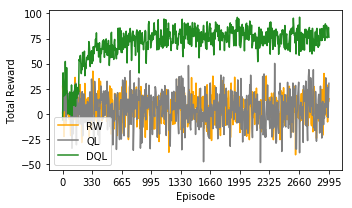

In [60]:
vil_log_results(values=[rw_log["total"], ql_log["total"], dql_log["total"]],
                names=["RW", "QL", "DQL"],
                colors=["orange", "gray", "forestgreen"],
                aspect="Total Reward",
                save_file="total.png")

<Figure size 432x288 with 0 Axes>

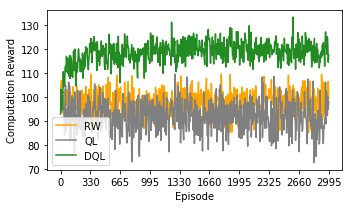

In [61]:
vil_log_results(values=[rw_log["computation"], ql_log["computation"], dql_log["computation"]],
                names=["RW", "QL", "DQL"],
                colors=["orange", "gray", "forestgreen"],
                aspect="Computation Reward",
                save_file="computation.png")

<Figure size 432x288 with 0 Axes>

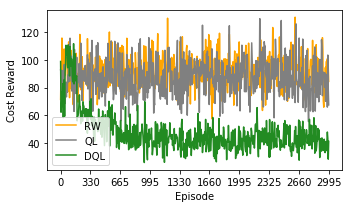

In [62]:
vil_log_results(values=[rw_log["cost"], ql_log["cost"], dql_log["cost"]],
                names=["RW", "QL", "DQL"],
                colors=["orange", "gray", "forestgreen"],
                aspect= "Cost Reward",
                save_file="cost.png")